In [1]:
import os
import glob
from dotenv import load_dotenv

load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TOGETHER_API_KEY"] = os.getenv("TOGETHER_API_KEY")
os.environ["MISTRAL_API_KEY"] = os.getenv("MISTRAL_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["HF_TOKEN"] = os.getenv("HF_TOKEN")

In [2]:
import os
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["LANGSMITH_API_KEY"]=os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"]="true"
os.environ["LANGSMITH_PROJECT"]="Network MultiAgent"

In [3]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="gemma2-9b-it")

In [4]:
from langgraph.graph import MessagesState, StateGraph,START,END
from langgraph.types import Command
from langchain_core.tools import tool
from typing_extensions import Literal

In [5]:
@tool
def transfer_to_travel_advisor():
    """Ask travel advisor for help."""
    return
@tool
def transfer_to_hotel_advisor():
    """Ask hotel advisor for help."""
    return

In [28]:
def travel_advisor(state: MessagesState) -> Command[Literal["hotel_advisor", "__end__"]]:
    system_prompt = """
    You are a general travel expert that can recommend travel destinations (e.g. countries, cities, etc).
    Your job is to recommend travel destinations based on user queries and provide:
    - Top places to visit in the destination (at least 3-5 with a short description for each)
    - Popular airlines or flight options available from the user's origin to the destination
    - For each destination, suggest a few hotel names (at least 2-3) that are well-known or highly rated
    Don't bother about budget or specific booking details, just provide general travel advice and options.
    Recommend when to travel and what are the best times to visit which places.
    If you need more detailed hotel recommendations, ask 'hotel_advisor' for help.
    Provide answers only on the user's query, not ask anything specific to provide.
    """
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    ai_msg = llm.bind_tools([transfer_to_hotel_advisor]).invoke(messages)
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(goto="hotel_advisor", update={"messages": [ai_msg, tool_msg]})
    return {"messages": [ai_msg]}


In [26]:
def hotel_advisor(state: MessagesState) -> Command[Literal["travel_advisor", "__end__"]]:
    system_prompt = """
    You are a hotel expert that can provide hotel recommendations for a given destination.
    Your role is to provide the best and most detailed hotel options based on user queries.
    Don't bother about budget or specific hotels, just provide the best service.
    For each destination, provide:
    - A list of top hotels (at least 3-5),
    - Their locations (city/area),
    - Key amenities (e.g., pool, gym, free breakfast, WiFi, etc.),
    - Hotel type (luxury, boutique, family-friendly, business, etc.),
    - Any unique features or highlights.
    Provide the best hotel options based on user queries and all types of hotels in California.
    If you need help picking travel destinations, ask 'travel_advisor' for help.
    Provide answers only on the user's query, not ask anything specific to provide.
    """
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    ai_msg = llm.bind_tools([transfer_to_travel_advisor]).invoke(messages)
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(goto="travel_advisor", update={"messages": [ai_msg, tool_msg]})
    return {"messages": [ai_msg]}


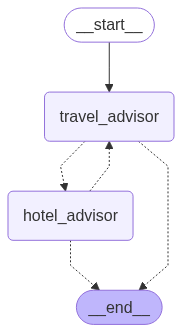

In [22]:
graph = StateGraph(MessagesState)
graph.add_node("travel_advisor", travel_advisor)
graph.add_node("hotel_advisor", hotel_advisor)

graph.add_edge(START, "travel_advisor")

builder = graph.compile()

builder

In [23]:
from langchain_core.messages import convert_to_messages
def pretty_print_messages(update):
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")

    for node_name, node_update in update.items():
        print(f"Update from node {node_name}:")
        print("\n")

        for m in convert_to_messages(node_update["messages"]):
            m.pretty_print()
        print("\n")

In [36]:
for chunk in builder.stream(
    {"messages": [{"role": "user", "content": "I am Planning to Travel to Maldives i need the flights from chennai on the following week with price of tickets for a couple and i need the best places to visit with avergae budget for a couple and  best hotels with name to stay for five days not be accurate just general based on your knowlwdge?"}]},
):
    print("****chunk****")
    
    pretty_print_messages(chunk)


****chunk****
Update from node travel_advisor:


================================== Ai Message ==================================
Tool Calls:
  transfer_to_hotel_advisor (6463qsxs6)
 Call ID: 6463qsxs6
  Args:
================================= Tool Message =================================

Successfully transferred


****chunk****
Update from node hotel_advisor:


================================== Ai Message ==================================

The Maldives offers a stunning array of islands, each with its own unique charm.  

For a memorable trip, consider visiting:

* **Malé:** The vibrant capital city boasts bustling markets, historical sites, and delicious seafood restaurants. 
* **Ari Atoll:** Known for its luxurious resorts and vibrant coral reefs, perfect for snorkeling and diving.
* **Baa Atoll:** A UNESCO Biosphere Reserve, home to diverse marine life and whale sharks. 

For a five-day trip, you could easily explore two of these destinations. 

Expect to spend around $150-$250